# Pulse Detection from Color Changes

Eulerian Video Magnification is based on : https://github.com/flyingzhao/PyEVM

Import all essential libraries

In [1]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import scipy.fftpack as fftpack
from scipy import signal, stats
from sklearn.decomposition import PCA, FastICA
%matplotlib inline

# Head/ROI Dectection

1) **harrCascadeFaceDet** :: Takes in an image and outputs the x,y co-ordinates of the upper left corner of the phase with the width and height as well<br/><br/>
2) **getFace** :: Takes in an image and a tuple with containg the (x,y,w,h) properties of a bounding box and outputs the facial reigon. The eyes are blacked out here<br/><br/>
3) **findMaxFace** :: Takes in a list of faces detected by the harcascade and outputs the (x,y,w,h) tuple corresponding to the face with the maximum area<br/><br/>

In [2]:
def harrCascadeFaceDet(image):
    # Define the Harr Cascade
    face_cascade = cv2.CascadeClassifier('./resources/haarcascade_frontalface_default.xml')
    # Use the cascade to extract the face
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    # Reain the regoin with the maxmimum face i.e facial reigon with the max area
    maxFaceIndex = findMaxFace(faces)
    (x,y,w,h) = faces[maxFaceIndex].copy()
    # Cropping Properties
    # Modify the x, y, w, h value to include only the central 50% of the total width and 90% of the total height
    x = int(x + 0.25 * w)
    w = int(w * 0.5)
    h = int(h * 0.9)
    # Round width and height to the nearst 2^level multiple
    # This is so that during the Pyramid reconstruction, the upsampling preserves original dimensions
    w = w + int(2**levels)
    w = w - (w % int(2**levels))
    h = h + int(2**levels)
    h = h - (h % int(2**levels))
    return (x,y,w,h)

def getFace(image, faceTuple):
    (x,y,w,h) = faceTuple
    # Extract the Cropped Facial Frame. Check the Function above for the Cropping Properties
    faceFrame = image[y:y + h, x:x+w, :]
    # Blacken out the eyes
    faceFrame[int(0.2*h):int(0.55*h), :, :] = 0
    return faceFrame
    

def findMaxFace(faces):
    # Find the facila region with max area
    # Usually in our case theres only one face. Hence, it gets detected as the max
    # But in the scenario with 2 faces, detect the max area
    maximum = -1
    for i,(x,y,w,h) in enumerate(faces):
        if(maximum < w * h):
            maximum = w * h
            n = i 
    return n

# Interpolate a set of time series data and Filter the interpolated data

Takes in the set of time series data as a matrix

1) Interpolation Paramters

**inputMatrix** => Each row is one time instance. Each column is one feature/corner point i.e. movement of 1-point across time<br/>
**inFr** => Input Sampling Frequency i.e. Frame Rate<br/>
**outFr** => Output Sampling Frequency (of the pulse oximeter)

2) Filter Parameters

**lowerCutoff** => Lower Cutoff Frequency in Hz <br/>
**higherCutoff** => Upper Cutoff Frequency in Hz <br/>
**filterOrder** => Filter Order of the ButterWorth Filter. Due to the use of filtfilt the filter order is actually twice of the specified value <br/>

The function interpolates each feature point(column) from the camera FPS rate to the oximeter rate. The interpolated columns are also bandpass filtered

In [3]:
def interpolationAndFiltering(inputMatrix, inFr, outFr, lowerCutoff=0.75, higherCutoff=5, filterOrder=5):
    rows, columns = inputMatrix.shape
    # Transfrom the cutoff frequencies from the analog domain to the digital domain
    lowerCutoffDigital = lowerCutoff / (0.5 * outFr)
    higherCutoffDigital = higherCutoff / (0.5 * outFr)
    Fr = outFr/inFr
    outputMatrix = np.zeros((int(Fr*rows), columns))
    for i in range(columns):
        #Interpolate the Data
        inputCol = inputMatrix[:,i]
        inputCol = cv2.resize(inputCol.reshape([len(inputCol.ravel()),1]), (1, int(Fr * rows)), interpolation = cv2.INTER_CUBIC)
        # Filter the data with a Butterworth bandpass filter and a filtfilt operation for a zero-phase response
        b, a = signal.butter(filterOrder, [lowerCutoffDigital, higherCutoffDigital], btype='band', analog=False)
        inputCol = signal.filtfilt(b, a, inputCol.ravel())
        outputMatrix[:,i] = inputCol.ravel()
    return outputMatrix

# Gaussian Video Pyramid Decomposition

1) **build_gaussian_pyramid** => Takes in an image and forms a Gaussian Pyramid. Levels need to be Specified

2) **gaussian_video** => Iterates through the video data(tensor form) and preapers a Gaussian Pyramid for each frame

In [4]:
def build_gaussian_pyramid(src,level=3):
    s=src.copy()
    pyramid=[s]
    for i in range(level):
        s=cv2.pyrDown(s)
        pyramid.append(s)
    return pyramid

# build gaussian pyramid for video
def gaussian_video(video_tensor,levels=3):
    for i in range(0,video_tensor.shape[0]):
        frame=video_tensor[i]
        pyr=build_gaussian_pyramid(frame,level=levels)
        gaussian_frame=pyr[-1]
        if i==0:
            vid_data=np.zeros((video_tensor.shape[0],gaussian_frame.shape[0],gaussian_frame.shape[1],3))
        vid_data[i]=gaussian_frame
    return vid_data

# Apply Temporal Ideal Bandpass Filter to Gaussian Video

Remove all components outside the range of a human heartbeat

**tensor** => The Tensor which containes the Gaussian Pyramid of each Frame<br/>
**low** => Lower Cutoff Frequency<br/>
**high** => Upper Cutoff Frequency<br/>
**fps** => Frame Rate of the Camera<br/>

In [5]:
def temporal_ideal_filter(tensor,low,high,fps,axis=0):
    fft=fftpack.fft(tensor,axis=axis)
    frequencies = fftpack.fftfreq(tensor.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff=fftpack.ifft(fft, axis=axis)
    return np.abs(iff)

# Reconstruct Video from Original Video and Gaussian Video

Takes the origianl video and adds the amplified changes to it

**amp\_video** => Amplified Video(Pyramid). Tensor Format<br/>
**origin\_video** => Origianl Video. Tendor Format<br/>
**levels** => Levels for Image Pyramid

In [6]:
def reconstructVideo(amp_video,origin_video,levels=3):
    final_video=np.zeros(origin_video.shape)
    for i in range(0,amp_video.shape[0]):
        img = amp_video[i]
        for x in range(levels):
            img=cv2.pyrUp(img)
        img=img+origin_video[i]
        final_video[i]=img
    return final_video

# Peak Amplification

Performs FFT peak and first harmonic amplification

1) Takes in a signal and the peak frequency<br/>
2) Prepares 2 filters at the max frequency and its first harmonic with the assigned Q factor<br/>
3) Filters the wave with each of the 2 filters seperately and then add thier results<br/>
4) Output i.e. a peak frequency enchanced version of the signal is returned <br/>

In [7]:
def peakAmplification(chosenSignal, outFr, f0, Q=2):
    b1, a1 = signal.iirpeak(f0, Q, outFr)
    peakFiltered = signal.filtfilt(b1, a1, chosenSignal.ravel())
    b2, a2 = signal.iirpeak(f0/2, Q, outFr)
    harmonicFiltered = signal.filtfilt(b2, a2, chosenSignal.ravel())
    return peakFiltered + harmonicFiltered

# Set the path for the Video File

In [17]:
path = './Dataset/Data/01-01.mp4' # Replace with the video source file
cap = cv2.VideoCapture(path) 
assert cap.isOpened(), 'Cannot capture source'

# Parameters and Constants

**inFr** => Input Frequency in Hz<br/>
**outFr** => Output Frequency in Hz<br/>
**amplification** => Amplification Factor for the Eulerian Video Magnification<br/>
**levels** => Levels for the Spatial Decomposition for Video Magnification<br/>

In [18]:
inFr  = int(cap.get(cv2.CAP_PROP_FPS))
outFr = 60
amplification = 20
levels = 3

# ROI Extraction

Read all the video frames, extract the facial region and save them in a list

In [19]:
counter = 0
videoTensor = []
while(True):
    ret, frame = cap.read()
    if ret == False:
        break
    # Convert to Grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if counter == 0:
        # Extract ROI
        faceTuple = harrCascadeFaceDet(gray)
    # Save ROI
    videoTensor.append(getFace(frame,faceTuple))        
    counter += 1
cap.release()
videoTensor = np.array(videoTensor)
print("Video Tensor Ready")

Video Tensor Ready


# Eulerian Video Magnification

Color Magnification of the Input Tensor

In [20]:
gau_video = gaussian_video(videoTensor,levels=levels)
print("Pyramid Fomation Complete. Shape :: ", gau_video.shape)
filtered_tensor = temporal_ideal_filter(gau_video,0.8,3,inFr)
print("Filter Complete")
amplifiedVideo = filtered_tensor * amplification
reconstructedTensor = reconstructVideo(amplifiedVideo,videoTensor,levels=levels)
print("Reconstruction Complete. Shape :: ", reconstructedTensor.shape)

Pyramid Fomation Complete. Shape ::  (2026, 22, 12, 3)
Filter Complete
Reconstruction Complete. Shape ::  (2026, 176, 96, 3)


# Global Averaging over the Width and Height and Interpolate


Sum over Width and Breadth to get the Time vs BGR components<br/>
Note : Format is B,G,R due to OpenCV<br/>

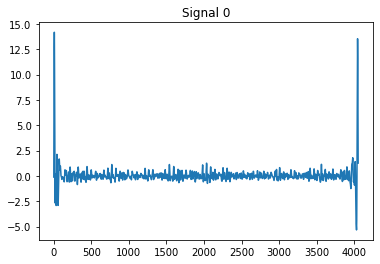

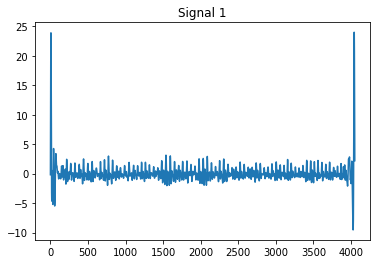

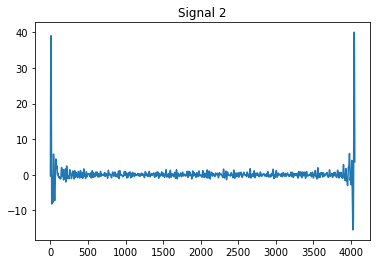

In [21]:
BGRComponents = np.mean(reconstructedTensor, axis = 1)
BGRComponents = np.mean(BGRComponents, axis = 1)
BGRComponents = interpolationAndFiltering(BGRComponents, inFr, outFr)

for i in range(3):
    plt.plot(BGRComponents[:,i])
    plt.title('Signal '+str(i))
    plt.show()

# Perform Component Analysis (Eg: PCA, ICA, etc..)

Used to remove the trend from the fluctuations<br/>
The fluctuation is the high frequency component (Pulse)<br/>
The trend is a very low frequency component<br/>
The actual input is a combination of both

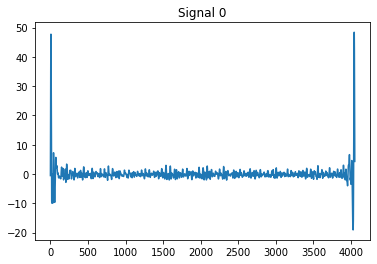

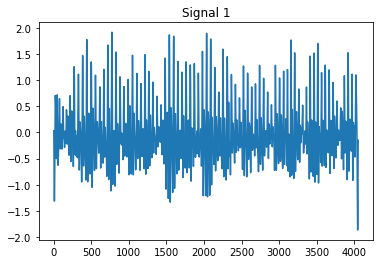

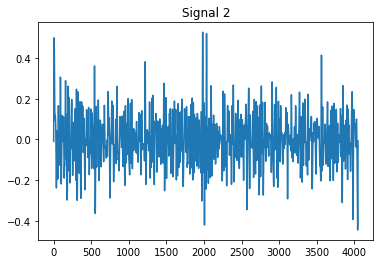

In [22]:
# Extract Components
model = PCA(n_components = 3)
principalComponents = model.fit_transform(BGRComponents)

for i in range(3):
    plt.plot(principalComponents[:,i])
    plt.title('Signal '+str(i))
    plt.show()

# Find the Best Component

1) Take each of the **3** components and analyze them to choose the best signal for the ECG estimation<br/>
2) Extract the power spectrum<br/>
3) Extract the Frequency component with the max energy (max power value) in itself and its harmonic<br/>
4) Find the ration between the above extracted power to the power in the whole power spectrum<br/>
5) Choose the signal with the Highest Ratio

In [23]:
nyquist = int(len(principalComponents)/2)  
x_disp = outFr/2*np.arange(nyquist)/nyquist
# Selecte Best Component. Usually the Second one i.e Index = 1
powerRatio = []
listForDistanceEstimation = []
for i in range(3):
    fftData = np.fft.fft(principalComponents[:,i])[0:nyquist]
    powerSpectrum = np.abs(fftData)**2
    maxFreq = np.argmax(powerSpectrum)
    powerInMaxFreq = np.sum(powerSpectrum[maxFreq-1:maxFreq+2]) + np.sum(powerSpectrum[2*maxFreq:2*maxFreq+3])
    powerRatio.append(powerInMaxFreq/np.sum(powerSpectrum))
    listForDistanceEstimation.append((maxFreq)/nyquist*outFr/2)
# Choose Signal 
PCAIndex = np.argmax(np.array(powerRatio))
chosenSignal = principalComponents[:,PCAIndex]

print("Chosen Signal :: ", PCAIndex)

Chosen Signal ::  1


# Amplify Peak and its First Harmonic

In [24]:
chosenSignal = peakAmplification(chosenSignal, outFr = outFr, f0 = listForDistanceEstimation[PCAIndex])

# Plot the Results

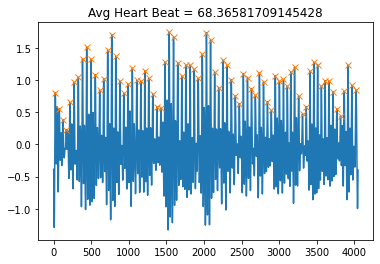

Number of Peaks ::  76


In [25]:
# Peak Det and Display

distance = int(outFr*1.6/listForDistanceEstimation[PCAIndex]) # Emperically found realtion via finetuning
peaks, _ = signal.find_peaks(chosenSignal, distance=distance)
plt.plot(chosenSignal)
plt.plot(peaks, chosenSignal[peaks], "x")
plt.title("Avg Heart Beat = "+str(60*60/(peaks[-1] - peaks[0])*len(peaks)))
plt.show()
print("Number of Peaks :: ", len(peaks))